In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, LSUN, CelebA
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random
from pathlib import Path

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist, DiscriminatorBhsLsun, GeneratorBhsLsun
from wgan import GeneratorWassersteinLsun, DiscriminatorWassersteinLsun
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein,get_dis_loss_kl, get_gen_loss_kl, get_dis_loss_rkl, get_gen_loss_rkl,
                     get_dis_loss_gan, get_gen_loss_gan, get_dis_loss_p, get_gen_loss_p)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, save_models_state_dict, load_model_state_dict, RevKlActivation, GanGanActivation
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import CIFAR10
from fid import InceptionV3
from dataset import SubCIFAR10
from fid import calculate_frechet

In [3]:
# create dataloader
batch_size = 128
device = get_device()
image_size = 64

train_transform = transforms.Compose([
        transforms.Resize(image_size),
        #transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = SubCIFAR10(root='cifar10/', transform=train_transform, download=True, include_list=[])

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers = 4)

Files already downloaded and verified


In [4]:
device

'cuda:0'

In [5]:
latent_dim = 100
latent_dim_bhs = 64*64
batch_size_bhs = 128
test_noise = torch.reshape(get_noise(25, latent_dim, device), (25, latent_dim, 1, 1))
test_noise_bhs = torch.reshape(get_noise(25, latent_dim_bhs, device), (25, latent_dim_bhs, 1, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


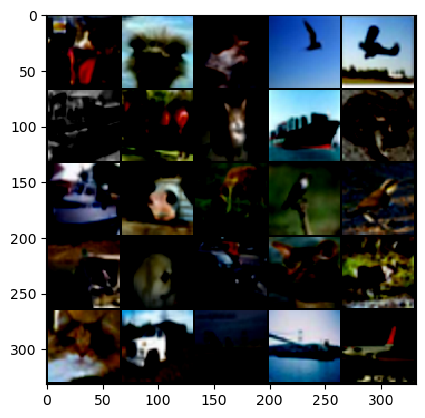

In [6]:
real_images = 0[:25][0]
image_grid_real = make_grid(real_images[:25], nrow=5)
plt.imshow(image_grid_real.permute(1, 2, 0).squeeze(), interpolation='nearest')

### Wasserstein GAN

In [7]:
training_params_wasserstein = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [8]:
save_path_wgan = "WGAN_CIFAR"
generator_wasserstein = GeneratorWassersteinLsun(z_dim=latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinLsun().apply(init_weights)
trainer_wgan = Trainer(training_params_wasserstein, generator_wasserstein, discriminator_wasserstein, device=device)

In [9]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, is_color_picture=True)

Epoch 1 start training...
Epoch: 1/50 Total Steps:391poch_Run_Time: 118.249200	Loss_C : -1.597096	Loss_G : 1.787336		
Total_Time : 118.897544
Loss_C : -1.597096
Loss_G : 1.787336
Loss_C_Mean : -4.181083
Loss_G_Mean : 0.882553

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:782poch_Run_Time: 118.716401	Loss_C : 0.291176	Loss_G : -5.287034		
Total_Time : 119.386265
Loss_C : 0.291176
Loss_G : -5.287034
Loss_C_Mean : -0.496247
Loss_G_Mean : -3.365580

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1173och_Run_Time: 117.411975	Loss_C : 0.278889	Loss_G : -9.076747		
Total_Time : 118.066807
Loss_C : 0.278889
Loss_G : -9.076747
Loss_C_Mean : 0.092256
Loss_G_Mean : -7.328915

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1564och_Run_Time: 117.466981	Loss_C : 0.223807	Loss_G : -11.162667		
Total_Time : 118.121372
Loss_C : 0.223807
Loss_G : -11.

In [10]:
save_models_state_dict(trained_wgan, save_path_wgan)

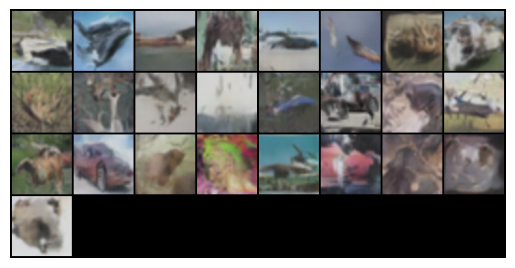

In [11]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25, size=(1, 64, 64), unflat=False, tanh_activation=True)

In [12]:
load_model_state_dict(generator_wasserstein, Path(save_path_wgan) / "generator.pt", map_location=device)

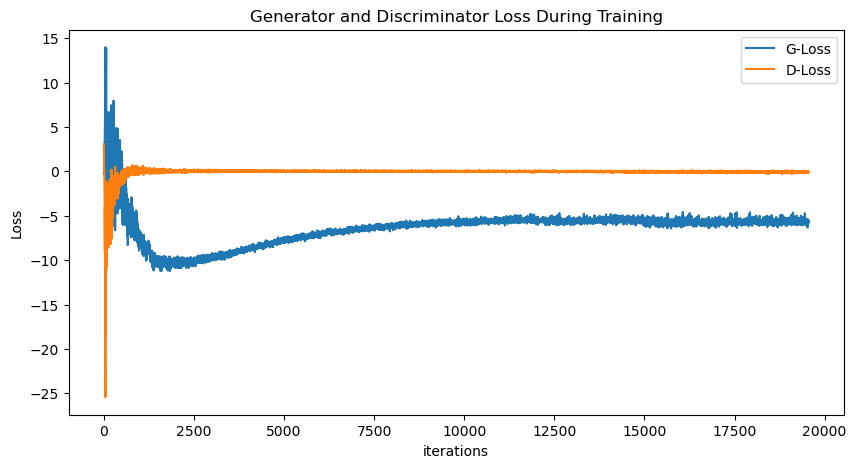

In [13]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

### BHS GAN

In [14]:
training_params_bhs = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [15]:
save_path_bhsgan = "BHSGAN_CIFAR"
final_activation = Positive
generator_bhs = GeneratorBhsLsun(z_dim=latent_dim_bhs, image_size=image_size).apply(init_weights)
discriminator_bhs = DiscriminatorBhsLsun(final_activation, image_size=image_size).apply(init_weights)
trainer_bhsgan = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [16]:
# training loop
trained_bhsgan = trainer_bhsgan.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, is_color_picture=True)

Epoch 1 start training...
Epoch: 1/50 Total Steps:391poch_Run_Time: 183.151536	Loss_C : 12.537110	Loss_G : -10.883514		5012	
Total_Time : 183.801368
Loss_C : 12.537110
Loss_G : -10.883514
Loss_C_Mean : 288.878362
Loss_G_Mean : -75.186385

----------------------------------------------

Epoch 2 start training...
Epoch: 2/50 Total Steps:782poch_Run_Time: 183.917942	Loss_C : -16.137274	Loss_G : -0.783461	
Total_Time : 184.544701
Loss_C : -16.137274
Loss_G : -0.783461
Loss_C_Mean : -2.254568
Loss_G_Mean : -1.834156

----------------------------------------------

Epoch 3 start training...
Epoch: 3/50 Total Steps:1173och_Run_Time: 182.729803	Loss_C : 1.547197	Loss_G : -1.418110		
Total_Time : 183.377815
Loss_C : 1.547197
Loss_G : -1.418110
Loss_C_Mean : -5.117241
Loss_G_Mean : -1.380874

----------------------------------------------

Epoch 4 start training...
Epoch: 4/50 Total Steps:1564och_Run_Time: 182.575891	Loss_C : -0.174427	Loss_G : -0.436109	
Total_Time : 183.206132
Loss_C : -0.1744

In [17]:
save_models_state_dict(trained_bhsgan, save_path_bhsgan)

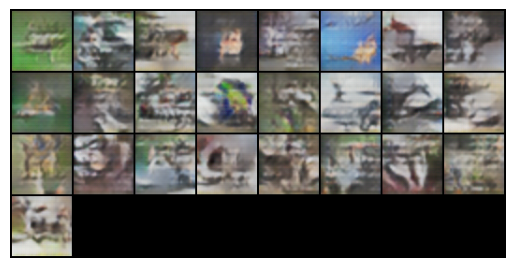

In [18]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=25, unflat=False, tanh_activation=True)

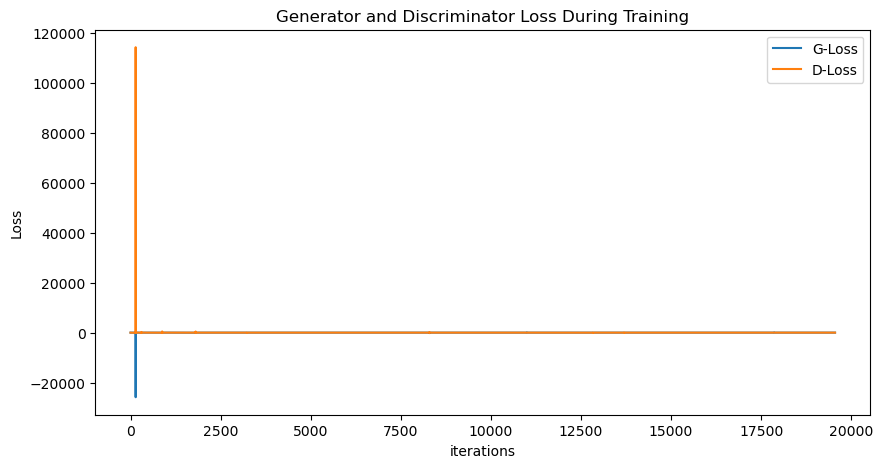

In [19]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## KL GAN

In [6]:
training_params_kl = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=35,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [7]:
save_path_klgan = "KLGAN_CIFAR"
final_activation = nn.Identity
generator_kl = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_kl = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_klgan = Trainer(training_params_kl, generator_kl, discriminator_kl, device=device)

In [ ]:
# training loop
trained_klgan = trainer_klgan.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, is_color_picture=True)

Epoch 1 start training...
Epoch: 1/35 Total Steps:391poch_Run_Time: 91.821901	Loss_C : 0.123317	Loss_G : -1.008961			
Total_Time : 92.785332
Loss_C : 0.123317
Loss_G : -1.008961
Loss_C_Mean : 0.372300
Loss_G_Mean : -0.698272

----------------------------------------------

Epoch 2 start training...
Epoch: 2/35 Total Steps:782poch_Run_Time: 86.967398	Loss_C : -0.092200	Loss_G : -1.034963	
Total_Time : 87.642119
Loss_C : -0.092200
Loss_G : -1.034963
Loss_C_Mean : -0.012865
Loss_G_Mean : -0.990441

----------------------------------------------

Epoch 3 start training...
Epoch: 3/35 Total Steps:1173och_Run_Time: 85.815455	Loss_C : -0.203698	Loss_G : -1.068821	
Total_Time : 86.720834
Loss_C : -0.203698
Loss_G : -1.068821
Loss_C_Mean : -0.204143
Loss_G_Mean : -1.015280

----------------------------------------------

Epoch 4 start training...
Epoch: 4/35 Total Steps:1564och_Run_Time: 93.688344	Loss_C : -0.033600	Loss_G : -1.005622	
Total_Time : 94.471192
Loss_C : -0.033600
Loss_G : -1.00562

In [ ]:
save_models_state_dict(trained_klgan, save_path_klgan)

In [ ]:
# show generated images
generated_images_kl = trained_klgan.generator(test_noise)
plot_tensor_images(generated_images_kl, num_images=25, unflat=False, tanh_activation=True)

In [ ]:
# plot losses
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

### RV KL GAN

In [ ]:
training_params_rkl = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [ ]:
save_path_rvklgan = "RVKLGAN_CIFAR"
final_activation = RevKlActivation
generator_rvkl = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_rvkl = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_rvklgan = Trainer(training_params_rkl, generator_rvkl, discriminator_rvkl, device=device)

In [ ]:
# training loop
trained_rvklgan = trainer_rvklgan.train_gan(dataloader, get_dis_loss_rkl, get_gen_loss_rkl, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_rvklgan, save_path_rvklgan)

In [ ]:
# show generated images
generated_images_rvkl = trained_rvklgan.generator(test_noise)
plot_tensor_images(generated_images_rvkl, num_images=25, unflat=False, tanh_activation=True)

In [ ]:
# plot losses
plot_losses(trained_rvklgan.generator_losses, trained_rvklgan.discriminator_losses)

### Standard GAN

In [ ]:
training_params_gan = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [ ]:
save_path_gan = "GAN_CIFAR"
final_activation = GanGanActivation
generator_gan = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_gan = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_gan = Trainer(training_params_gan, generator_gan, discriminator_gan, device=device)

In [ ]:
# training loop
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_gan, save_path_gan)

In [ ]:
# show generated images
generated_images_gan = trained_gan.generator(test_noise)
plot_tensor_images(generated_images_gan, num_images=25, unflat=False, tanh_activation=True)

In [ ]:
# plot losses
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)

### Pearson GAN

In [ ]:
training_params_pearson = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=50,
                                 num_dis_updates=4,
                                 num_gen_updates=3,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [ ]:
save_path_pearsongan = "PEARSONGAN_CIFAR"
final_activation = nn.Identity
generator_pearson = GeneratorBhsLsun(z_dim=latent_dim).apply(init_weights)
discriminator_pearson = DiscriminatorBhsLsun(final_activation).apply(init_weights)
trainer_pearsongan = Trainer(training_params_pearson, generator_pearson, discriminator_pearson, device=device)

In [ ]:
# training loop
trained_pearsongan = trainer_pearsongan.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, is_color_picture=True)

In [ ]:
save_models_state_dict(trained_pearsongan, save_path_pearsongan)

In [ ]:
# show generated images
generated_images_pearson = trained_pearsongan.generator(test_noise)
plot_tensor_images(generated_images_pearson, num_images=25, unflat=False, tanh_activation=True)

In [ ]:
# plot losses
plot_losses(trained_pearsongan.generator_losses, trained_pearsongan.discriminator_losses)

### Evaluate with FID

In [ ]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

In [ ]:
# sample onr batch of real data
real_images = iter(dataloader)._next_data()
# generate noise
fid_noise = torch.reshape(get_noise(128, latent_dim, device), (25, latent_dim, 1, 1))
fid_noise_bhs = torch.reshape(get_noise(128, latent_dim_bhs, device), (25, latent_dim_bhs, 1, 1))

In [ ]:
# get generators

In [ ]:
# generate images

In [ ]:
fid_wasserstein = calculate_frechet(real_images , generated_images_wasserstein, model)
fid_wasserstein

In [ ]:
fid_bhs = calculate_frechet(real_images , generated_images_bhs, model)
fid_bhs

In [ ]:
fid_kl = calculate_frechet(real_images , generated_images_kl, model)
fid_kl

In [ ]:
fid_rvkl = calculate_frechet(real_images , generated_images_rvkl, model)
fid_rvkl

In [ ]:
fid_gan = calculate_frechet(real_images , generated_images_gan, model)
fid_gan

In [ ]:
fid_pearson = calculate_frechet(real_images , generated_images_pearson, model)
fid_pearson